In [ ]:
#@title Import modules
import time
import copy
import os
import random
import pandas as pd
import json
import cv2

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import PercentFormatter
from numpy.polynomial.polynomial import polyfit
from PIL import Image, ImageShow
from IPython.display import clear_output
import numpy as np
import shutil
import scipy.stats as stats
import statsmodels.api as sm
from datetime import datetime
import collections
from matplotlib.gridspec import GridSpec

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from torch.nn.functional import normalize
import torch.nn.functional as F
from torchvision import transforms, utils, models, datasets
import torchvision

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from scipy.stats import spearmanr, pearsonr, sem

from collections import OrderedDict

import pandas as pd
from tqdm import trange, tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Setup


In [ ]:
#@title Dataset Path
cwd = os.getcwd()
proj_dir = cwd
dir_model = cwd + "/Models/"
dir_sta = cwd + "/statistics/"
dir_ratings = cwd + "/Ratings_BOLD5000.csv"
dir_BOLD5000 = cwd + "/images/BOLD5000_Stimuli/all_presented_images"
model_data_dir = cwd + "/model_data/"

In [ ]:
#@title hook
visualisation = {}
def hook_fn(m, i, o):
  visualisation[m] = o.detach()

def get_all_layers(net):
  for name, layer in net._modules.items():
    #If it is a sequential, don't register a hook on it
    # but recursively register hook on all it's module children
    if isinstance(layer, nn.Sequential):
      get_all_layers(layer)
    else:
      # it's a non sequential. Register a hook
      layer.register_forward_hook(hook_fn)

def compute_neuron_activation(model, inputs, key_list):
  data_to_record = list(visualisation.values())
  return data_to_record

In [ ]:
#@title Generate the layer index list (vgg19)
layer_types = [torch.nn.modules.linear.Linear, torch.nn.modules.conv.Conv2d]
vgg1 = models.vgg19(pretrained=False)
get_all_layers(vgg1)
visualisation = {}
x = torch.randn(1,3,375,375) * 100
out = vgg1(x)
layer_index = []
layer_names_list = list(visualisation.keys())
for i in range(len(layer_names_list)):
  # if i > 0:
    if type(layer_names_list[i]) in layer_types:
      layer_index.append(i)
# layer_index.append(44)
layer_index = layer_index[:-1]
print(layer_index)
print(len(layer_index))

# Compute the number of elements in each layer of interest
num_elements = []
for i in layer_index:
  layer_num_ele = visualisation[layer_names_list[i]].numel()
  num_elements.append(layer_num_ele)
print(num_elements)
# np.savetxt(model_data_dir+'num_neurons_vgg19.csv', np.array(num_elements), delimiter=',', fmt='%s')

[0, 2, 5, 7, 10, 12, 14, 16, 19, 21, 23, 25, 28, 30, 32, 34, 38, 41]
18
[9000000, 9000000, 4476032, 4476032, 2214144, 2214144, 2214144, 2214144, 1083392, 1083392, 1083392, 1083392, 270848, 270848, 270848, 270848, 4096, 4096]


In [ ]:
#@title Generate the layer index list (Resnet50)
layer_types = [torch.nn.modules.linear.Linear, torch.nn.modules.conv.Conv2d, torchvision.models.resnet.Bottleneck]
model = models.resnet50(pretrained=False).to(device)
get_all_layers(model)
visualisation = {}
x = torch.randn(1,3,375,375).to(device)
out = model(x)
layer_index = []
layer_names_list = list(visualisation.keys())
for i in range(len(layer_names_list)):
  # if i > 0:
    if type(layer_names_list[i]) in layer_types:
      layer_index.append(i)
# layer_index.append(44)
layer_index = layer_index[:-1]
print(layer_index)
print(len(layer_index))

# Compute the number of elements in each layer of interest
num_elements = []
for i in layer_index:
  layer_num_ele = visualisation[layer_names_list[i]].numel()
  num_elements.append(layer_num_ele)
print(num_elements)
# np.savetxt(model_data_dir+'num_neurons_resnet50.csv', np.array(num_elements), delimiter=',', fmt='%s')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
17
[2262016, 2262016, 2262016, 2262016, 1131008, 1131008, 1131008, 1131008, 589824, 589824, 589824, 589824, 589824, 589824, 294912, 294912, 294912]


In [ ]:
#@title data transformation
data_transforms = {
    'resolution_375*375': transforms.Compose([
        transforms.Resize(375),
        transforms.CenterCrop(375),
        transforms.ToTensor()
    ])
}

In [ ]:
#@title Metabolic cost calculation functions
def sparseness_compute_l1norm(
    activations,
    s_type='L1'
    ):
  if s_type == "L1":
    sparseness = torch.stack([torch.sum(torch.abs(activations[i])) for i in range(activations.size()[0])]).to(device)
  elif s_type == "exponential":
    sparseness = torch.stack([-torch.sum(-torch.exp(-torch.pow(activations[i], 2))) for i in range(activations.size()[0])]).to(device)
  elif s_type == "logarithmic":
    sparseness = torch.stack([-torch.sum(torch.log(1 + torch.pow(activations[i], 2))) for i in range(activations.size()[0])]).to(device)
  return sparseness


def compute_sparsity_change(model, inputs, s_type='L1'):
  """
  Compute the total reward of a given model.
  """
  neuron_activations = compute_neuron_activation(model, inputs)
  model_out = neuron_activations[-1]

  neuron_sparseness = []
  for activation in neuron_activations:
    if type(activation) != int:
      neuron_sparseness.append(sparseness_compute_l1norm(activation))
    else:
      neuron_sparseness.append(0)

  sparseness_change = [neuron_sparseness[i+1] - neuron_sparseness[i]
                       for i in range(len(neuron_sparseness)-1)
                       if type(neuron_sparseness[i]) == type(neuron_sparseness[i+1])]

  return sparseness_change, neuron_activations


def sparseness_compute_binary(activations):
  sparseness = torch.stack([torch.count_nonzero(activations[i]) for i in range(activations.size()[0])]).to(device)
  return sparseness


def compute_activation_change_binary(model, inputs):
  """
  Compute the total reward of a given model.
  """
  neuron_activations = compute_neuron_activation(model, inputs)

  neuron_sparsity = []
  for activation in neuron_activations:
    if type(activation) != int:
      neuron_sparsity.append(sparseness_compute_binary(activation))
    else:
      neuron_sparsity.append(0)

  sparseness_change = [neuron_sparsity[i+1] - neuron_sparsity[i]
                       for i in range(len(neuron_sparsity)-1)
                       if type(neuron_sparsity[i]) == type(neuron_sparsity[i+1])]

  return sparseness_change, neuron_activations


def compute_sparseness(
    model,
    inputs,
    key_list
    ):
  """
  Compute both the L1-norm version and binary version sparseness.
  """
  neuron_activations = compute_neuron_activation(model, inputs, key_list)

  neuron_sparsity_l1norm = []
  neuron_sparsity_binary = []
  for activation in neuron_activations:
    neuron_sparsity_binary.append(sparseness_compute_binary(activation))
    neuron_sparsity_l1norm.append(sparseness_compute_l1norm(activation))

  return (neuron_sparsity_binary, neuron_sparsity_l1norm), neuron_activations

In [ ]:
#@title Utils

def loader(path):
  img = cv2.imread(dir_BOLD5000 + '/' + path, cv2.IMREAD_UNCHANGED)
  img = Image.fromarray(img).convert('RGB')
  # img = Image.open(dir_BOLD5000 + '/' + path).convert('RGB')
  img = data_transforms['val'](img).unsqueeze(0).to(device)
  return img

def cal_r_squared(
    model,
    X,
    y
    ):
  yhat = model.predict(X)
  SS_Residual = sum((y-yhat)**2)
  SS_Total = sum((y-np.mean(y))**2)
  r_squared = 1 - (float(SS_Residual))/SS_Total
  adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-len(X)-1)
  return r_squared, adjusted_r_squared

def measure_activation_range(
    input_tensor
    ):
  max = torch.max(input_tensor)
  min = torch.min(input_tensor)
  return min, max

def divide_subset(names, indices_lst):
  imgs = {'Scenes':[], 'COCO': [], 'ImageNet':[]}
  length = len(names)
  for i in range(length):
    imgs['Scenes'].append([indices_lst[i][k] for k in range(len(names[i])) \
                      if ((not names[i][k].startswith('COCO'))
                      & (not names[i][k].startswith('n0'))
                      & (not names[i][k].startswith('n1')))])
    imgs['COCO'].append([indices_lst[i][k] for k in range(len(names[i])) if names[i][k].startswith('COCO')])
    imgs['ImageNet'].append([indices_lst[i][k] for k in range(len(names[i])) \
                      if ((names[i][k].startswith('n1'))
                      or (names[i][k].startswith('n0')))])
  return imgs


def coef_compute(metabolic_costs, ratings_to_predict):
  regression = LinearRegression()

  results = []
  for i in range(len(metabolic_costs[0])):
    l = [metabolic_costs[j][:i+1] for j in range(len(metabolic_costs))]
    regression.fit(l, ratings_to_predict)
    results.append(regression.coef_[-1])
  results = np.array(results)

  return results

def compute_R_squared(train_x, validate_x, train_y, validate_y):
  regression = LinearRegression()

  results = []
  for i in range(len(train_x[0])):
    l = [train_x[j][:i+1] for j in range(len(train_x))]
    regression.fit(l, train_y)
    l_val = [validate_x[j][:i+1] for j in range(len(validate_x))]
    r_2, _ = cal_r_squared(regression, l_val, validate_y)
    results.append(r_2)

  individual_account = [results[i+1]-results[i] for i in range(len(results)-1)]
  individual_account.insert(0, results[0])

  return results, individual_account

# Experiment

In [ ]:
#@title dataset preparation

In [ ]:
file_dir = proj_dir + 'data_for_regression.csv'
df = pd.read_csv(file_dir)
pleasure_ratings = np.array(df['pleasure_rating'])
complexity_ratings = np.array(df['complexity_rating'])

In [ ]:
#@title 10-fold partioning
df_ratings = pd.read_csv(dir_ratings)
pleasure_ratings = np.array(df_ratings['pleasure_rating'])
complexity_ratings = np.array(df_ratings['complexity_rating'])
name_list = list(df_ratings['name'])
df_sparsity_data = pd.DataFrame()
length = len(name_list)

train_set, test_set = [], []
train_ind_set, test_ind_set = [], []
kf = KFold(n_splits=10, shuffle=True, random_state=0) # seed 0
for train_index, test_index in kf.split(name_list):
  # print("TRAIN:", train_index, "TEST:", test_index)
  # print('train len:', len(train_index))
  # print('test len:', len(test_index))
  train_ind_set.append(list(train_index))
  test_ind_set.append(list(test_index))
  train_set.append([name_list[ind] for ind in train_index])
  test_set.append([name_list[ind] for ind in test_index])

In [ ]:
#@title dataset and loader
def loader(path, transform_mode='val'):
  img = cv2.imread(dir_BOLD5000 + '/' + path, cv2.IMREAD_UNCHANGED)
  img = Image.fromarray(img).convert('RGB')
  # img = Image.open(dir_BOLD5000 + '/' + path).convert('RGB')
  img = data_transforms['resolution_375*375'](img).unsqueeze(0).to(device)
  return img

In [ ]:
class MyDataSet(Data.Dataset):
  def __init__(self, paths, loader=loader):
    super(MyDataSet, self).__init__()
    self.images = paths
    self.loader = loader

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    fn = self.images[idx]
    img = self.loader(fn).squeeze()
    return img, self.images[idx]

In [ ]:
test_dataset = MyDataSet(name_list,loader=loader)
batch_size=32
MyDataLoader = Data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
#@title (pretrained) compute both binary and l1norm

model_names = ['resnet50', 'vgg19']
model_name = model_names[0]

start_time = time.time()
for i in range(1):

  # load model
  if model_name == 'resnet50':
    resnet_model_path = "/resnet50_robust_linf_8_255_untargeted_cutmixfrontpatchres_hvyaug_epoch3_score0.43526743297617587_best.pth"
    state_dict = torch.load(dir_model + resnet_model_path,
                            map_location=torch.device('cpu'))["model"]
    model = models.resnet50(pretrained=False).to(device)
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
      # strip `module.` prefix
      if "efnet" in k and not "attacker" in k:
          name = k.replace("module.model.", "")
          name = k.replace('efnet_model.', "")
          new_state_dict[name] = v
    model.load_state_dict(new_state_dict)
    model = model.to(device)
  elif model_name == 'vgg19':
    model = models.vgg19(pretrained=True).to(device)

  # set eval mode and set hook
  model.eval()
  get_all_layers(model)
  for params in model.parameters():
    params.require_grad = False

  list_single_layer_l1norm, list_single_layer_binary = [], []
  j = 0
  start_time_ = time.time()

  with torch.set_grad_enabled(False):

    for img, _ in MyDataLoader:

      img = img.to(device)
      visualisation = {}
      out = model(img)
      key_list = list(visualisation.keys())
      x, _ = compute_sparseness(model=model, inputs=img, key_list=key_list)
      size = x[0][0].shape[0]

      for m in range(size):
        single_layer_l1norm = [int(x[1][n][m]) for n in range(len(x[0]))]
        single_layer_binary = [int(x[0][n][m]) for n in range(len(x[1]))]

        list_single_layer_l1norm.append(single_layer_l1norm)
        list_single_layer_binary.append(single_layer_binary)

      j += size
      print(f'pretrained_model, ' + str(j) + ' of ' + str(length))
      clear_output(wait=True)

  col_name = f'pretrained_model'

  del model
  df_ratings = pd.read_csv(dir_ratings)

  df_ratings[col_name+'_single'+'_l1norm'] = list_single_layer_l1norm
  df_ratings[col_name+'_single'+'_binary'] = list_single_layer_binary


  print(time.time() - start_time_, "seconds")

  # save the data
  df_ratings.to_csv(
      model_data_dir+f'{model_name}_hook_pretrained_model.csv',
      index=False,
      sep=','
      )
  # del df_ratings

print(time.time() - start_time, "seconds")

In [ ]:
#@title (untrained) compute both binary and l1norm

model_names = ['resnet50', 'vgg19']
model_name = model_names[0]

start_time = time.time()
for i in [248,380,455,508,899,988,769]:

  # set random seed
  torch.manual_seed(i)

  # load model
  if model_name == 'resnet50':
    model = models.resnet50(pretrained=False).to(device)
  elif model_name == 'vgg19':
    model = models.vgg19(pretrained=False).to(device)

  # set eval mode and set hook
  model.eval()
  get_all_layers(model)
  for params in model.parameters():
    params.require_grad = False

  list_single_layer_l1norm, list_single_layer_binary = [], []
  j = 0
  start_time_ = time.time()

  with torch.set_grad_enabled(False):

    for img, _ in MyDataLoader:

      img = img.to(device)
      visualisation = {}
      out = model(img)
      key_list = list(visualisation.keys())
      x, _ = compute_sparseness(model=model, inputs=img, key_list=key_list)
      size = x[0][0].shape[0]

      for m in range(size):
        single_layer_l1norm = [int(x[1][n][m]) for n in range(len(x[0]))]
        single_layer_binary = [int(x[0][n][m]) for n in range(len(x[1]))]

        list_single_layer_l1norm.append(single_layer_l1norm)
        list_single_layer_binary.append(single_layer_binary)

      j += size
      print(f'model-{i}, ' + str(j) + ' of ' + str(length))
      clear_output(wait=True)

  col_name = f'model_{i+1}'

  del model
  df_ratings = pd.read_csv(model_data_dir+f'{model_name}_hook_'+'all_'+'untrained_model.csv')

  df_ratings[col_name+'_single'+'_l1norm'] = list_single_layer_l1norm
  df_ratings[col_name+'_single'+'_binary'] = list_single_layer_binary


  print(time.time() - start_time_, "seconds")

  # save the data
  df_ratings.to_csv(
      model_data_dir+f'{model_name}_hook_'+'all_'+'untrained_model.csv',
      index=False,
      sep=','
      )
  del df_ratings

print(time.time() - start_time, "seconds")

In [ ]:
#@title Calculate the correlation between total activations and ratings

model_names = ['vgg19']
model_name = model_names[0]

pretrained = False
dir = model_data_dir
loi_index = layer_index
print(loi_index)
hook = True

if pretrained:
  if hook:
    df = pd.read_csv(dir+f'{model_name}_hook_pretrained_model.csv')
  type_ = '_pretrained'
else:
  if hook:
    df = pd.read_csv(dir+f'{model_name}_hook_all_'+'untrained_model.csv')
  type_ = '_untrained'

number_untrained = 1000
ind = 1 # binary -- 1, l1norm -- 0
sparsity_condition = ['_l1norm', '_binary'][ind]
regressor_condition = '_single'
print(sparsity_condition)

# regression model fit
regression_pleasure = LinearRegression()

mean_fz_ple = []
alphas_ple = []
p_value = []

if pretrained:
  num_turn = 1
else:
  num_turn = number_untrained

m_costs = []
corr_list = []

for i in trange(0, num_turn):
  # load the data for model i
  if pretrained == False:
    if hook:
      metabolic_costs = [
          sum(
              [json.loads(
          df[f'model_{i+1}' + regressor_condition + sparsity_condition][m]
          )[layer]
          for layer in loi_index]
          )
      for m in range(df.shape[0])]
    else:
      metabolic_costs = [sum(json.loads(df[f'model_{i+1}' + regressor_condition + sparsity_condition][m])) for m in range(df.shape[0])]

  else:
    if hook:
      metabolic_costs = [sum([json.loads(df['pretrained_model' + regressor_condition + sparsity_condition][m])[layer] for layer in loi_index]) for m in range(df.shape[0])]
    else:
      metabolic_costs = [sum(json.loads(df['pretrained_model' + regressor_condition + sparsity_condition][m])) for m in range(df.shape[0])]

  # compute correlation
  m_costs.append(np.mean(metabolic_costs))
  corr_list.append(spearmanr(metabolic_costs, pleasure_ratings)[0])
  p_value.append(spearmanr(metabolic_costs, pleasure_ratings)[1])


print('\n', np.mean(corr_list))

# save the statistics
if pretrained:
  df = pd.DataFrame(columns=['metabolic_costs', 'pleasure'])
  df['metabolic_costs'] = metabolic_costs
  df['pleasure'] = pleasure_ratings
  df.to_csv(model_data_dir+'correlation_data/'+ model_name + f'/{model_name}_{sparsity_condition[1:]}_correlation_raw_data.csv')
  np.savetxt(model_data_dir+'correlation_data/'+ model_name +f'/{model_name}_{sparsity_condition[1:]}_correlation_total_activations_pretrained.csv', np.array(corr_list), delimiter=',', fmt='%s')
  np.savetxt(model_data_dir+'correlation_data/'+ model_name +f'/{model_name}_{sparsity_condition[1:]}_pval_total_activations_pretrained.csv', p_value, delimiter=',', fmt='%s')
else:
  np.savetxt(model_data_dir+'correlation_data/'+ model_name +f'/{model_name}_{sparsity_condition[1:]}_correlation_total_activations_untrained.csv', np.array(corr_list), delimiter=',', fmt='%s')
  np.savetxt(model_data_dir+'correlation_data/'+ model_name +f'/{model_name}_{sparsity_condition[1:]}_pval_total_activations_untrained.csv', p_value, delimiter=',', fmt='%s')


In [ ]:
#@title regression prediction: the predictive power of metabolic costs

# load the dataset
pretrained = True
hook = True
k_fold = 10
model_name = ['resnet50', 'vgg19'][0]
dir = model_data_dir + f'regression_data/{model_name}_/alltrainable_'
loi_index = layer_index
print(loi_index)
np.savetxt(dir+f'{model_name}_layer_index_list.csv',
           loi_index,
           delimiter=',',
           fmt='%s'
           )

if pretrained:
  if hook:
    df = pd.read_csv(model_data_dir+f'{model_name}_hook_pretrained_model.csv')
  else:
    df = pd.read_csv(model_data_dir+f'{model_name}_pretrained_model.csv')
  type_ = '_pretrained'
else:
  if hook:
    df = pd.read_csv(model_data_dir+f'{model_name}_hook_all_'+'untrained_model.csv')
  else:
    df = pd.read_csv(model_data_dir+f'{model_name}_all_'+'untrained_model.csv')
  type_ = '_untrained'

number_untrained = 1000
ind = 0
sparsity_condition = ['_l1norm', '_binary'][ind]
sparsity_condition_ = ['_l1norm', '_binary'][ind]
regressor_condition = ['_single'][0]

# regression model fit
regression_pleasure = LinearRegression()

r_list_ple = []
alphas_ple = []
variance_accounted_cuml = []
variance_accounted_individual = []

if pretrained:
  num_turn = 1
else:
  num_turn = number_untrained

for i in trange(0, num_turn):

  pred_ple_list = []
  gt_ple_list = []

  # load the data for model i
  if pretrained == False:
    if hook:
      regressors = [[json.loads(df[f'model_{i+1}' + regressor_condition
                                   + sparsity_condition][m])[layer]
                     for layer in loi_index]
                    for m in range(df.shape[0])]
    else:
      regressors = [json.loads(df[f'model_{i+1}' + regressor_condition
                                  + sparsity_condition][m])
                    for m in range(df.shape[0])]
  else:
    if hook:
      regressors = [[json.loads(df['pretrained_model' + regressor_condition
                                   + sparsity_condition][m])[layer]
                     for layer in loi_index]
                    for m in range(df.shape[0])]

    else:
      regressors = [
          json.loads(
              df['pretrained_model'
                  + regressor_condition
                  + sparsity_condition][m]
                     )
          for m in range(df.shape[0])
          ]

  regressors = np.array(regressors)

  # K-fold validation
  for j in range(k_fold):
    regression_pleasure = LinearRegression()

    regressors_train = [regressors[m] for m in train_ind_set[j]]
    pleasure_ratings_train = [pleasure_ratings[m] for m in train_ind_set[j]]

    pleasure_ratings_test = [pleasure_ratings[m] for m in test_ind_set[j]]
    regressors_test = [regressors[m] for m in test_ind_set[j]]

    # fit the models

    cumulative_account, individual_account = compute_R_squared(regressors_train,
                                                               regressors_test,
                                                               pleasure_ratings_train,
                                                               pleasure_ratings_test
                                                               )

    variance_accounted_cuml.append(cumulative_account)
    variance_accounted_individual.append(individual_account)

    regression_pleasure.fit(
        regressors_train,
        pleasure_ratings_train
        )

    ple_coef = regression_pleasure.coef_

    alphas_ple.append(ple_coef)

    # make predictions and save prediction-truth pairs
    pred_ple = regression_pleasure.predict(regressors_test)
    pred_ple_list.extend(pred_ple)
    gt_ple = pleasure_ratings_test
    gt_ple_list.extend(gt_ple)

  r_list_ple.append(spearmanr(pred_ple_list, gt_ple_list)[0])

# save the data
print(r_list_ple)
np.savetxt(
    dir+sparsity_condition_ + regressor_condition + type_ + "_final_cor_pleasure.csv",
    r_list_ple,
    delimiter=',',
    fmt='%s'
    )

variance_accounted_cuml_mean, variance_accounted_individual_mean = [], []
for i in range(len(variance_accounted_cuml[0])):
  if pretrained:
    variance_accounted_cuml_mean.append(
        np.mean([variance_accounted_cuml[k][i] for k in range(k_fold)])
        )
    np.savetxt(
        dir + sparsity_condition_ + regressor_condition + type_ + '_variance_accounted_cumulative.csv',
        variance_accounted_cuml_mean,
        delimiter=',',
        fmt='%s'
        )

for i in range(len(variance_accounted_individual[0])):
  if pretrained:
    variance_accounted_individual_mean.append(
        np.mean([variance_accounted_individual[k][i] for k in range(k_fold)])
        )
    np.savetxt(
        dir + sparsity_condition_ + regressor_condition + type_ + '_variance_accounted_individual.csv',
        variance_accounted_individual_mean,
        delimiter=',',
        fmt='%s'
        )

if pretrained == True:
  df = pd.DataFrame()
  df['pred'] = np.array(pred_ple_list)
  df['gt'] = np.array(gt_ple_list)
  df.to_csv(
      dir + sparsity_condition_ + regressor_condition + type_ + '_df_for_correlation.csv',
      index=False,
      sep=','
      )

[0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

[0.3127649406025603]


In [ ]:
#@title (Image subset: COCO, ImageNet, Scene) Regression prediction: the predictive power of metabolic cost
subset_names = ['Scenes', 'COCO', 'ImageNet']
res_r = {name: 0 for name in subset_names}
res_p = {name: 0 for name in subset_names}

for subset_name in subset_names:
  subset_train_ind_set = divide_subset(names=train_set, indices_lst=train_ind_set)[subset_name]
  subset_test_ind_set = divide_subset(names=test_set, indices_lst=test_ind_set)[subset_name]
  # load the dataset
  pretrained = True
  hook = True
  k_fold = 10
  model_name = ['resnet50', 'vgg19'][1]
  dir = model_data_dir + f'regression_data/{model_name}_/alltrainable_'
  loi_index = layer_index
  print(loi_index)
  np.savetxt(dir+f'{model_name}_layer_index_list.csv',
            loi_index,
            delimiter=',',
            fmt='%s'
            )

  if pretrained:
    if hook:
      df = pd.read_csv(model_data_dir+f'{model_name}_hook_pretrained_model.csv')
    else:
      df = pd.read_csv(model_data_dir+f'{model_name}_pretrained_model.csv')
    type_ = '_pretrained'
  else:
    if hook:
      df = pd.read_csv(model_data_dir+f'{model_name}_hook_all_'+'untrained_model.csv')
    else:
      df = pd.read_csv(model_data_dir+f'{model_name}_all_'+'untrained_model.csv')
    type_ = '_untrained'

  number_untrained = 1000
  ind = 0
  sparsity_condition = ['_l1norm', '_binary'][ind]
  sparsity_condition_ = ['_l1norm', '_binary'][ind]
  regressor_condition = ['_single'][0]

  # regression model fit
  regression_pleasure = LinearRegression()

  r_list_ple = []
  p_list_ple = []
  alphas_ple = []
  variance_accounted_cuml = []
  variance_accounted_individual = []

  if pretrained:
    num_turn = 1
  else:
    num_turn = number_untrained

  for i in trange(0, num_turn):

    pred_ple_list = []
    gt_ple_list = []

    # load the data for model i
    if pretrained == False:
      if hook:
        regressors = [[json.loads(df[f'model_{i+1}' + regressor_condition
                                    + sparsity_condition][m])[layer]
                      for layer in loi_index]
                      for m in range(df.shape[0])]
      else:
        regressors = [json.loads(df[f'model_{i+1}' + regressor_condition
                                    + sparsity_condition][m])
                      for m in range(df.shape[0])]
    else:
      if hook:
        regressors = [[json.loads(df['pretrained_model' + regressor_condition
                                    + sparsity_condition][m])[layer]
                      for layer in loi_index]
                      for m in range(df.shape[0])]

      else:
        regressors = [
            json.loads(
                df['pretrained_model'
                    + regressor_condition
                    + sparsity_condition][m]
                      )
            for m in range(df.shape[0])
            ]

    regressors = np.array(regressors)

    # K-fold validation
    for j in range(k_fold):
      regression_pleasure = LinearRegression()

      regressors_train = [regressors[m] for m in subset_train_ind_set[j]]
      pleasure_ratings_train = [pleasure_ratings[m] for m in subset_train_ind_set[j]]

      pleasure_ratings_test = [pleasure_ratings[m] for m in subset_test_ind_set[j]]
      regressors_test = [regressors[m] for m in subset_test_ind_set[j]]

      # fit the models

      cumulative_account, individual_account = compute_R_squared(regressors_train,
                                                                regressors_test,
                                                                pleasure_ratings_train,
                                                                pleasure_ratings_test
                                                                )

      variance_accounted_cuml.append(cumulative_account)
      variance_accounted_individual.append(individual_account)

      regression_pleasure.fit(
          regressors_train,
          pleasure_ratings_train
          )

      ple_coef = regression_pleasure.coef_

      alphas_ple.append(ple_coef)

      # make predictions and save prediction-truth pairs
      pred_ple = regression_pleasure.predict(regressors_test)
      pred_ple_list.extend(pred_ple)
      gt_ple = pleasure_ratings_test
      gt_ple_list.extend(gt_ple)

    r_list_ple.append(spearmanr(pred_ple_list, gt_ple_list)[0])
    p_list_ple.append(spearmanr(pred_ple_list, gt_ple_list)[1])

  # save the data
  # fz_ple = np.array(fz_ple)
  print(r_list_ple)
  res_r[subset_name] = r_list_ple[0]
  res_p[subset_name] = p_list_ple[0]

res_r = pd.DataFrame([res_r])
res_p = pd.DataFrame([res_p])
res_r.to_csv(model_data_dir+f'regression_data/{model_name}_subset_pred_r.csv')
res_p.to_csv(model_data_dir+f'regression_data/{model_name}_subset_pred_p.csv')


[0, 2, 5, 7, 10, 12, 14, 16, 19, 21, 23, 25, 28, 30, 32, 34, 38, 41]


100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


[0.38725327525327524]
[0, 2, 5, 7, 10, 12, 14, 16, 19, 21, 23, 25, 28, 30, 32, 34, 38, 41]


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


[0.47533743748751256]
[0, 2, 5, 7, 10, 12, 14, 16, 19, 21, 23, 25, 28, 30, 32, 34, 38, 41]


100%|██████████| 1/1 [00:01<00:00,  1.78s/it]

[0.42068433929398064]


# Figures and Analyses


0.018
0.2156066299439528 0.3174145803937133 _l1norm
0.1511779750821684 0.291192290163235 _binary
_l1norm   0.1450245401301245
_binary   0.1330102815795927


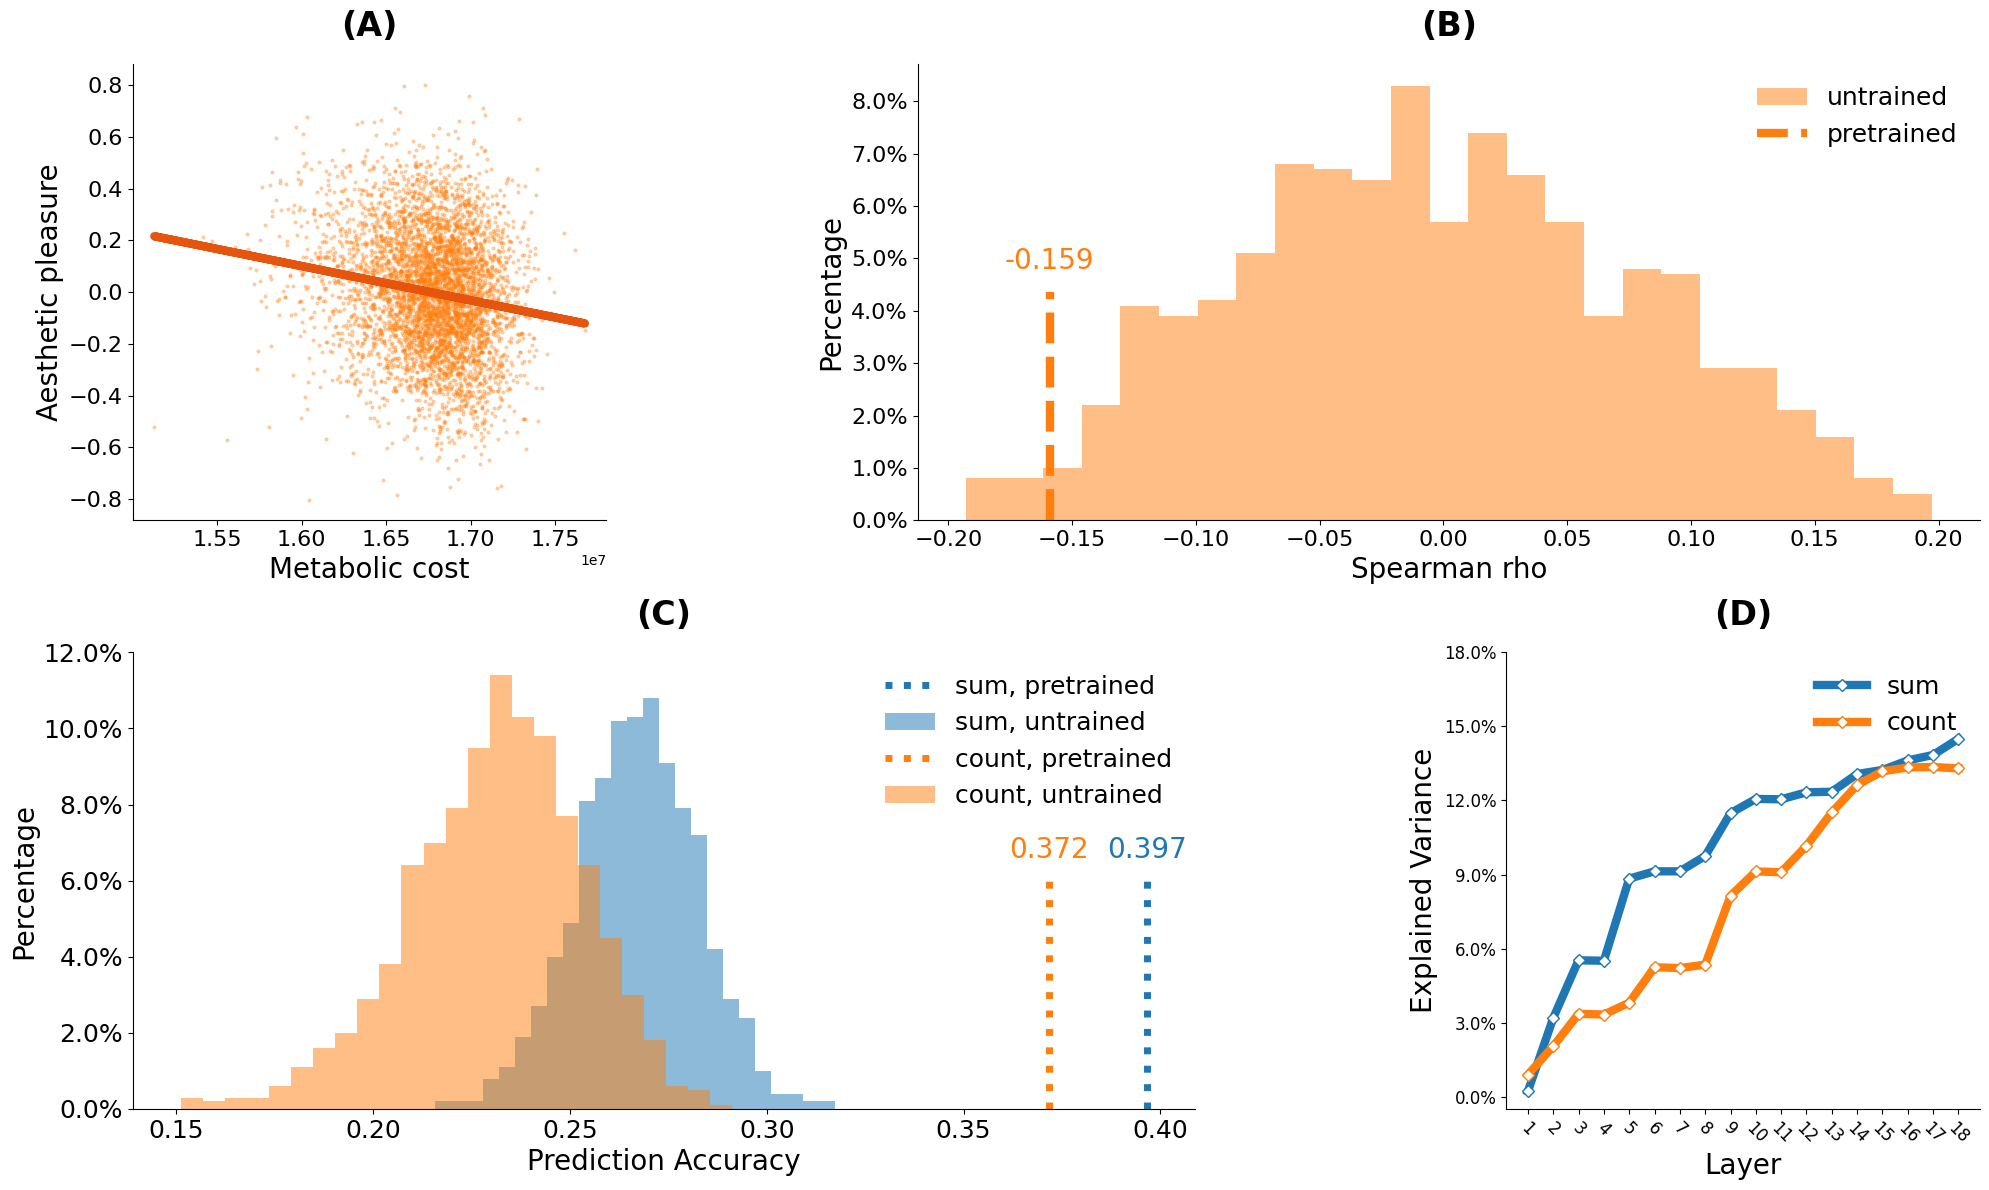

In [ ]:
#@title Figure 2
fig = plt.figure(figsize=(20, 12))
gs = GridSpec(nrows=2, ncols=10)
axis_label_size = 20
title_padding = 20
num_bins = 25
legend_fontsize = 18
text_fontsize = 20
title_size = 24

## Panel A: Correlation
ax1 = fig.add_subplot(gs[0, :3])
model_name = ['vgg19'][0]
sparsity_condition = ['l1norm', 'binary'][1]

df = pd.read_csv(model_data_dir+'correlation_data/'+ model_name + f'/{model_name}_{sparsity_condition}_correlation_raw_data.csv')
x=df['metabolic_costs']
y=df['pleasure']
ax1.scatter(x, y, s=4, color='tab:orange', alpha=0.3)
b, m = polyfit(x, y, 1)
ax1.plot(x, b + m * x, color='#e6550d', linewidth=6)

ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.set_xlabel('Metabolic cost', fontsize=axis_label_size)
ax1.set_ylabel('Aesthetic pleasure', fontsize=axis_label_size)

# Getting the right spine of the plot
right_spine = plt.gca().spines['right']
upper_spine = plt.gca().spines['top']
# Removing the right spine
right_spine.set_visible(False)
upper_spine.set_visible(False)
ax1.set_title('(A)', fontsize=title_size, pad=title_padding, fontweight='bold')

## Panel B: Null Distribution
ax2 = fig.add_subplot(gs[0,4:])
df = pd.read_csv(
    model_data_dir+'correlation_data/'+model_name+f'/{model_name}_{sparsity_condition}_correlation_total_activations_untrained.csv',
    header=None
    )
untrained = np.array(df[0])
df_pretrained = pd.read_csv(
    model_data_dir+'correlation_data/'+model_name+f'/{model_name}_{sparsity_condition}_correlation_total_activations_pretrained.csv',
    header=None
    )
pretrained_value = df_pretrained[0][0]
ax2.hist(untrained, bins=num_bins, weights=np.ones(len(untrained)) / len(untrained), alpha=0.5, color='tab:orange', label='untrained')
ax2.axvline(x=pretrained_value, ymin=0, ymax=0.5, linewidth=6, color='tab:orange', linestyle='dashed', label='pretrained')
ax2.set_ylabel('Percentage', fontsize=axis_label_size)
ax2.set_xlabel('Spearman rho', fontsize=axis_label_size)
ax2.tick_params(axis='both', which='major', labelsize=16)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
print(np.where(pretrained_value > untrained)[0].shape[0]/1000)
# show values for the pretrained model
_, y_max = ax2.get_ylim()
ax2.text(
    pretrained_value,
    0.55*y_max,
    f'{round(pretrained_value, 3)}',
    ha='center',
    color='tab:orange',
    fontsize=text_fontsize)

# Getting the right spine of the plot
right_spine = plt.gca().spines['right']
upper_spine = plt.gca().spines['top']
# Removing the right spine
right_spine.set_visible(False)
upper_spine.set_visible(False)
ax2.legend(frameon=False, fontsize=legend_fontsize)
ax2.set_title('(B)', fontsize=title_size, pad=title_padding, fontweight='bold')


## Panel C: Prediction accuracy distributions
ax3 = fig.add_subplot(gs[1,:6])
sparsity_condition = ['_l1norm', '_binary']
regressor_condition = '_single'
model_name = ['resnet50', 'vgg19'][1]
label_name = ['sum', 'count'] # ['sum', 'count']
dir = model_data_dir + f'regression_data/{model_name}_/alltrainable_'

colors = ['tab:blue', 'tab:orange']
untrained_colors = colors
pretrained_colors = colors

y_max = 0.12

for count1, condition1 in enumerate(sparsity_condition):

  # Get data
  mean_cor_ple_null = pd.read_csv(
      dir
      +condition1
      +regressor_condition
      +'_untrained'+"_final_cor_pleasure.csv",
      header=None
      ).values.squeeze()
  print(np.min(mean_cor_ple_null), np.max(mean_cor_ple_null), condition1)
  mean_cor_ple_target = pd.read_csv(
      dir
      +condition1
      +regressor_condition
      +'_pretrained'
      +"_final_cor_pleasure.csv",
      header=None
      )[0][0]

  # Plots
  ax3.axvline(
    x=mean_cor_ple_target,
    color=pretrained_colors[count1],
    ymin=0,
    ymax=0.5,
    label=label_name[count1]+', pretrained',
    linewidth=5,
    linestyle='dotted'
    )
  ax3.hist(
    mean_cor_ple_null,
    bins = num_bins,
    weights=np.ones(1000)/1000,
    label=label_name[count1]+', untrained',
    color=untrained_colors[count1],
    alpha=0.5
    )
  # print(condition1, np.min(mean_fz_ple), np.max(mean_fz_ple))
  # print(np.std(mean_fz_ple), np.mean(mean_fz_ple))


  # show values for the pretrained model
  if y_max == 0:
    _, y_max = ax3.get_ylim()
  ax3.text(
      mean_cor_ple_target,
      0.55*y_max,
      f'{round(mean_cor_ple_target, 3)}',
      ha='center',
      color=pretrained_colors[count1],
      fontsize=text_fontsize)

ax3.set_ylim(0, 0.12)
ax3.set_xlim(0.13890904263634732, 0.4088255564444113)
ax3.legend(fontsize=legend_fontsize, frameon=False)
ax3.set_xlabel('Prediction Accuracy', fontsize=axis_label_size)
ax3.set_ylabel('Percentage', fontsize=axis_label_size)
ax3.tick_params(axis='both', which='major', labelsize=16)

# Getting the right spine of the plot
right_spine = plt.gca().spines['right']
upper_spine = plt.gca().spines['top']
# Removing the right spine
right_spine.set_visible(False)
upper_spine.set_visible(False)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax3.set_title('(C)', fontsize=title_size, pad=title_padding, fontweight='bold')


## Panel D: explained variance
ax4 = fig.add_subplot(gs[1,7:])
dir = model_data_dir + f'regression_data/{model_name}_/alltrainable_'
sparsity_condition_ = ['_l1norm', '_binary']
regressor_condition = ['_single'][0]
label_name = ['sum', 'count']

for n, measure_type in enumerate(sparsity_condition_):
  type_ = '_pretrained'
  df = pd.read_csv(dir+measure_type+regressor_condition+type_+'_variance_accounted_cumulative.csv', header=None)
  ax4.plot(list(df[0]), marker='D', markerfacecolor='white', linewidth=6, label=label_name[n])
  print(measure_type, ' ', list(df[0])[-1])
  ax4.set_xticks([i for i in range(len(list(df[0])))], [i+1 for i in range(len(list(df[0])))])

ax4.legend(fontsize=legend_fontsize, frameon=False, loc='upper right')
ax4.set_yticks([0.03*i for i in range(7)])
plt.xticks(rotation=-45)
# Getting the right spine of the plot
right_spine = plt.gca().spines['right']
upper_spine = plt.gca().spines['top']
# Removing the right spine
right_spine.set_visible(False)
upper_spine.set_visible(False)

ax4.tick_params(axis='both', which='major', labelsize=12)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax4.set_ylabel('Explained Variance', fontsize=axis_label_size)
ax4.set_xlabel('Layer', fontsize=axis_label_size)

ax4.set_title('(D)', fontsize=title_size, pad=title_padding, fontweight='bold')
plt.tight_layout()
plt.savefig('figure_2.png')

_l1norm 0.1735897766513491 0.3094336289572048
0.020885560201788483 0.2546240393770563
_l1norm   0.0954903872656829


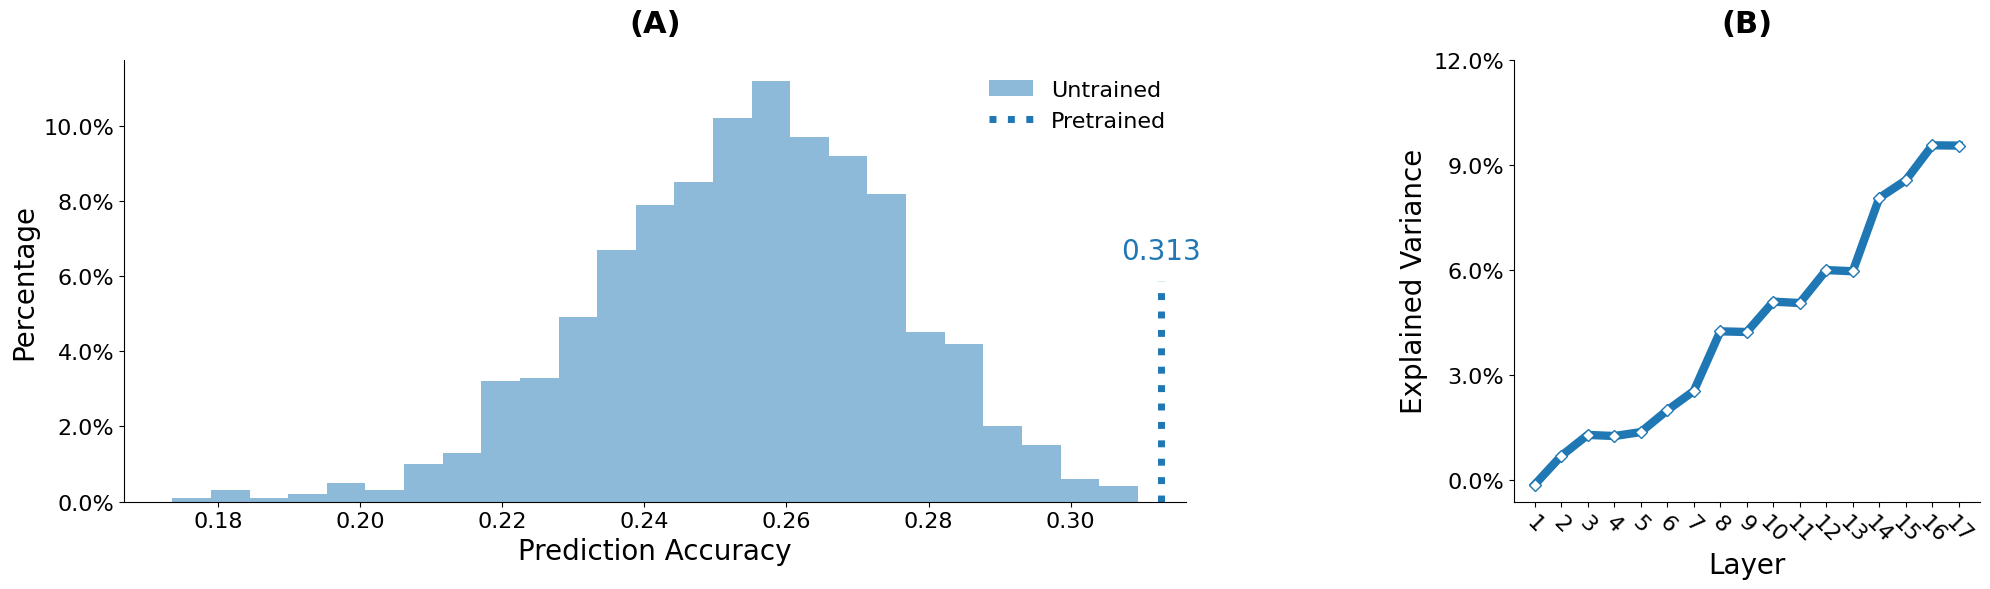

In [ ]:
#@title Figure S1
fig = plt.figure(figsize=(20,6))
gs = GridSpec(nrows=1, ncols=10)
axis_label_size = 20
title_padding = 20
num_bins = 25
text_fontsize = 20
## Panel A: distributions
ax1 = fig.add_subplot(gs[0,:6])
sparsity_condition = ['_l1norm']
regressor_condition = '_single'
model_name = ['resnet50', 'vgg19'][0]
label_name = ['sum']
dir = model_data_dir + f'regression_data/{model_name}_/alltrainable_'

colors = ['tab:blue', 'tab:orange']
untrained_colors = colors
pretrained_colors = colors

y_max = 0

for count1, condition1 in enumerate(sparsity_condition):

  # Get data
  mean_cor_ple_null = pd.read_csv(
      dir
      +condition1
      +regressor_condition
      +'_untrained'+"_final_cor_pleasure.csv",
      header=None
      ).values.squeeze()
  mean_cor_ple_target = pd.read_csv(
      dir
      +condition1
      +regressor_condition
      +'_pretrained'
      +"_final_cor_pleasure.csv",
      header=None
      )[0][0]

  # Plots
  ax1.hist(
      mean_cor_ple_null,
      bins = num_bins,
      weights=np.ones(1000)/1000,
      label='Untrained',
      color=untrained_colors[count1],
      alpha=0.5
      )
  print(condition1, np.min(mean_cor_ple_null), np.max(mean_cor_ple_null))
  print(np.std(mean_cor_ple_null), np.mean(mean_cor_ple_null))
  ax1.axvline(
      x=mean_cor_ple_target,
      color=pretrained_colors[count1],
      ymin=0,
      ymax=0.5,
      label='Pretrained',
      linewidth=5,
      linestyle='dotted'
      )

  # show values for the pretrained model
  if y_max == 0:
    _, y_max = ax1.get_ylim()
  ax1.text(
      mean_cor_ple_target,
      0.55*y_max,
      f'{round(mean_cor_ple_target, 3)}',
      ha='center',
      color=pretrained_colors[count1],
      fontsize=text_fontsize)


ax1.legend(fontsize=16, frameon=False)
ax1.set_xlabel('Prediction Accuracy', fontsize=axis_label_size)
ax1.set_ylabel('Percentage', fontsize=axis_label_size)
ax1.tick_params(axis='both', which='major', labelsize=16)

# Getting the right spine of the plot
right_spine = plt.gca().spines['right']
upper_spine = plt.gca().spines['top']
# Removing the right spine
right_spine.set_visible(False)
upper_spine.set_visible(False)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax1.set_title('(A)', fontsize=22, pad=title_padding, fontweight='bold')



## Panel B: explained variance
ax2 = fig.add_subplot(gs[0,7:])
dir = model_data_dir + f'regression_data/{model_name}_/alltrainable_'
sparsity_condition_ = ['_l1norm']
regressor_condition = ['_single'][0]
label_name = ['sum']

for n, measure_type in enumerate(sparsity_condition_):
  type_ = '_pretrained'
  df = pd.read_csv(dir+measure_type+regressor_condition+type_+'_variance_accounted_cumulative.csv', header=None)
  ax2.plot(list(df[0]), marker='D', markerfacecolor='white', linewidth=6, label=label_name[n])
  print(measure_type, ' ', list(df[0])[-1])
  ax2.set_xticks([i for i in range(len(list(df[0])))], [i+1 for i in range(len(list(df[0])))])

plt.yticks([0.03*i for i in range(5)])
plt.xticks(rotation=-45)
# Getting the right spine of the plot
right_spine = plt.gca().spines['right']
upper_spine = plt.gca().spines['top']
# Removing the right spine
right_spine.set_visible(False)
upper_spine.set_visible(False)

ax2.tick_params(axis='both', which='major', labelsize=16)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.ylabel('Explained Variance', fontsize=axis_label_size)
plt.xlabel('Layer', fontsize=axis_label_size)

ax2.set_title('(B)', fontsize=22, pad=title_padding, fontweight='bold')

plt.tight_layout()
plt.savefig('SI_regression_resnet.png')


In [ ]:
# Check the number of negative significant correlations in 1000 null models
df_cor = pd.read_csv(model_data_dir+'correlation_data/'+ 'vgg19/'+'binary_correlation_total_activations_untrained.csv')
df_pval = pd.read_csv(model_data_dir+'correlation_data/'+ 'vgg19/'+'binary_pval_total_activations_untrained.csv')
l1 = np.array(df_cor.iloc[:,0])
l2 = list(df_pval.iloc[:,0])
l_result = []
negative_index = list(np.where(l1 < 0)[0])
for i in negative_index:
  if l2[i] < 0.05:
    l_result.append(i)
len(l_result)

396